# Classification of Wind Gusts

In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import plot_partial_dependence
import pickle

## Sample data

In [2]:
Met_20170701 = Dataset(  # Metar Training
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar Testing
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')

## Format metar data

In [3]:
met_gust_1 = Met_20170701.variables['windGust']
met_lon_1 = Met_20170701.variables['longitude']
met_lat_1 = Met_20170701.variables['latitude']
met_temp_1 = Met_20170701.variables['temperature']
met_windspeed_1 = Met_20170701.variables['windSpeed']
met_winddir_1 = Met_20170701.variables['windDir']
met_press_1 = Met_20170701.variables['seaLevelPress']

met_gust_2 = Met_20180613.variables['windGust']
met_lon_2 = Met_20180613.variables['longitude']
met_lat_2 = Met_20180613.variables['latitude']
met_temp_2 = Met_20180613.variables['temperature']
met_windspeed_2 = Met_20180613.variables['windSpeed']
met_winddir_2 = Met_20180613.variables['windDir']
met_press_2 = Met_20180613.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, wd, p in zip(met_gust_1, met_lon_1, met_lat_1, 
                                     met_temp_1, met_windspeed_1, met_winddir_1, met_press_1):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, wd, p))

for g, lon, lat, t, ws, wd, p in zip(met_gust_2, met_lon_2, met_lat_2, 
                                     met_temp_2, met_windspeed_2, met_winddir_2, met_press_2):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, wd, p))

met_pos = np.asarray(cell)

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


### Creating GustLevel

Can be used to train a classification model. 

In [26]:
met_df = pd.DataFrame(
    {'MetWindGust': met_pos[:, 0],
     'Longitude': met_pos[:, 1],
     'Latitude': met_pos[:, 2],
     'Temperature': met_pos[:, 3],
     'WindSpeed': met_pos[:, 4],
     'WindDirection': met_pos[:, 5],
     'Pressure': met_pos[:, 6]})

met_df = met_df.round(4)
met_df = met_df.replace(np.NaN, 0)
met_df['GustLevel'] = pd.cut(met_df.MetWindGust, bins=[0, 5, 10, 100], labels=False, right=True, include_lowest=True)
met_df

,MetWindGust,Longitude,Latitude,Temperature,WindSpeed,WindDirection,Pressure,GustLevel
0,0.0,-112.37,33.42,315.15,2.5722,0.0,0.0,0
1,0.0,-117.78,34.10,301.15,5.1444,260.0,0.0,0
2,0.0,-111.72,40.22,301.15,2.0578,0.0,0.0,0
3,0.0,-123.43,48.43,292.15,5.6589,160.0,0.0,0
4,0.0,-123.30,49.10,293.15,1.0289,290.0,0.0,0
...,...,...,...,...,...,...,...,...
8718,0.0,-76.37,37.08,293.15,2.1000,200.0,102000.0,0
8719,0.0,-77.03,38.85,294.85,5.1000,180.0,0.0,0
8720,0.0,-73.34,49.28,290.35,0.0000,0.0,100480.0,0
8721,9.3,-67.43,48.47,289.75,6.7000,340.0,100070.0,1


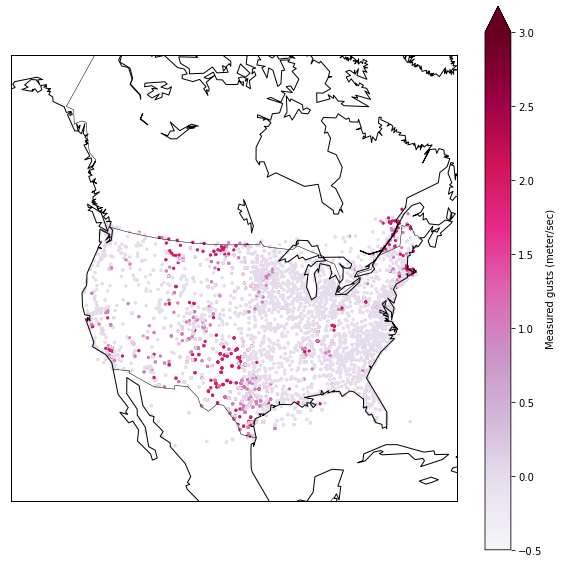

In [28]:
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='c',
            width=6E6, height=6E6,
            lat_0=45, lon_0=-100, )
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
parallels = np.arange(0., 81, 10.)
meridians = np.arange(10., 351., 20.)

m.scatter(met_df.Longitude, met_df.Latitude, latlon=True, c=met_df.GustLevel,
          cmap='PuRd', vmin=-0.5, vmax=3, s=5)

plt.colorbar(label='Measured gusts (meter/sec)', extend='max')

plt.show()